### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulate Signal

In [3]:
def sim_sig_np(bf,be,tm,adc,sigma,axr,nvox):
    
    be_tiled = np.tile(be,(nvox,1))
    bf_tiled = np.tile(bf,(nvox,1))
    tm_tiled = np.tile(tm,(nvox,1))

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm_tiled[(tm_tiled == np.min(tm_tiled)) & (bf_tiled == 0)] = np.inf

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled* np.exp(-tm_tiled*axr_tiled))
    normalised_signal_tiled = np.exp(-adc_prime_tiled * be_tiled)
    
    return normalised_signal_tiled, adc_prime_tiled


In [4]:
def sim_sig_pytorch(bf, be, tm, adc_tiled, sigma_tiled, axr_tiled, batch_size):
    """batch_size and nvox are kind of interchangable
    might be useful to know for testing purposes
    """
    be_tiled = torch.tile(be,(batch_size,1))
    bf_tiled = torch.tile(bf,(batch_size,1))
    tm_tiled = torch.tile(tm,(batch_size,1))

    """
    use this section for testing if function works as intended    
    adc_tiled = torch.tile(adc,(tm.shape[0],1)).t()
    sigma_tiled = torch.tile(sigma,(tm.shape[0],1)).t()
    axr_tiled = torch.tile(axr,(tm.shape[0],1)).t()
    """

    tm_tiled[(tm_tiled == torch.min(tm_tiled)) & (bf_tiled == 0)] = float('inf')
    

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled * torch.exp(-tm_tiled * axr_tiled))
    normalised_signal_tiled = torch.exp(-adc_prime_tiled * be_tiled)

    return normalised_signal_tiled, adc_prime_tiled

### Initial variables.

In [5]:
nvox = 1000 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e-3   # filter b-values [ms/um2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e-3       # encoding b-values [ms/um2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32)  # mixing time [ms]


sim_adc = np.random.uniform(0.1,3.5,nvox)               # ADC, simulated [um2/ms]
sim_sigma = np.random.uniform(0,1,nvox)                 # sigma, simulated [a.u.]
sim_axr = np.random.uniform(0.1,20,nvox) * 1e-3         # AXR, simulated [ms-1]

sim_E_vox, sim_adc_prime = sim_sig_np(bf,be,tm,sim_adc,sim_sigma,sim_axr,nvox)

In [6]:
"""sim_adc1 = torch.tensor(sim_adc)
sim_sigma1 = torch.tensor(sim_sigma)
sim_axr1 = torch.tensor(sim_axr)
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)

sim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)"""

'sim_adc1 = torch.tensor(sim_adc)\nsim_sigma1 = torch.tensor(sim_sigma)\nsim_axr1 = torch.tensor(sim_axr)\nbe = torch.tensor(be)\nbf = torch.tensor(bf)\ntm = torch.tensor(tm)\n\nsim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)'

### Histogram plots

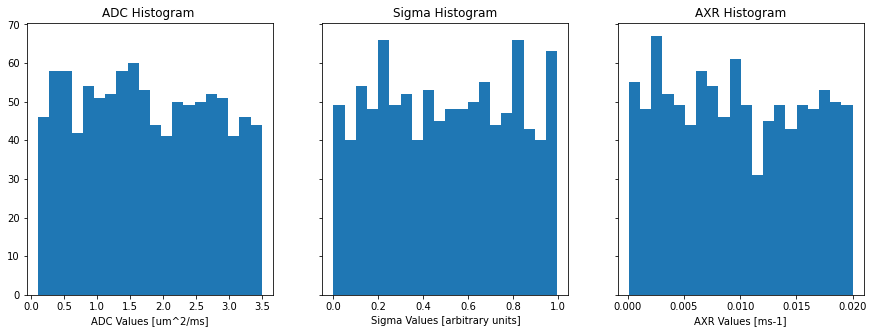

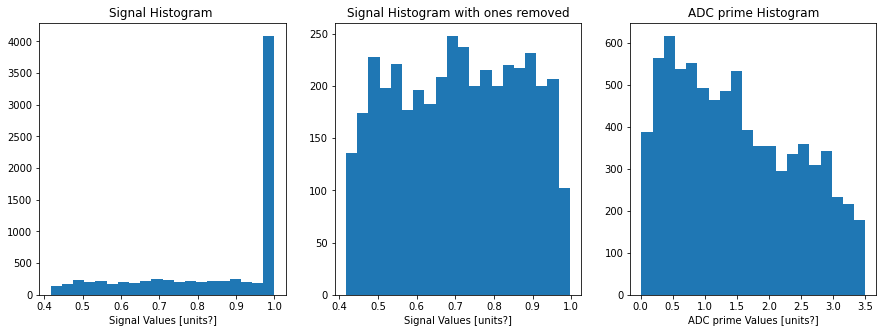

In [7]:
n_bins=20
#make 200 and voxels 100,000 to see adc prime dropoff
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(15, 5))
axs[0].hist(sim_adc, bins=n_bins)
axs[1].hist(sim_sigma, bins=n_bins)
axs[2].hist(sim_axr, bins=n_bins)
axs[0].set_title('ADC Histogram ')
axs[0].set_xlabel('ADC Values [um^2/ms]')
axs[1].set_title('Sigma Histogram')
axs[1].set_xlabel('Sigma Values [arbitrary units]')
axs[2].set_title('AXR Histogram')
axs[2].set_xlabel('AXR Values [ms-1]');


fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].hist(sim_E_vox.flatten(), bins=n_bins)
axs[0].set_title('Signal Histogram ')
axs[0].set_xlabel('Signal Values [units?]')
axs[1].hist(sim_E_vox[sim_E_vox != 1].flatten(), bins=n_bins)
axs[1].set_title('Signal Histogram with ones removed')
axs[1].set_xlabel('Signal Values [units?]')
axs[2].hist(sim_adc_prime.flatten(), bins=n_bins)
axs[2].set_title('ADC prime Histogram')
axs[2].set_xlabel('ADC prime Values [units?]');


### Plotting b-value against normalised signal

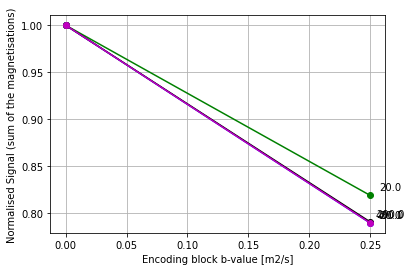

In [8]:
plt.plot([be[0], be[1]], [sim_E_vox[0,0], sim_E_vox[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], sim_E_vox[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [sim_E_vox[0,2], sim_E_vox[0,3]], 'go-')
plt.annotate(tm[2], (be[3], sim_E_vox[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [sim_E_vox[0,4], sim_E_vox[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], sim_E_vox[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [sim_E_vox[0,6], sim_E_vox[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], sim_E_vox[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()


### Least squares fit

In [ ]:
init = np.array([1.1, .15, 3.5 * 1e-3 ])
lb = np.array([.1, 0, .1 * 1e-3 ])
ub = np.array([3.5, 1, 20 * 1e-3 ])

#scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None,)


In [ ]:
#==========================================================================
# Calculate sum of square error between mixing time estimate vs adc and true value. 
# Inputs    - free_params:  parameter values being fitted
#                           [adc sigma axr] 
#           - scheme:       acquisition parameters [nx3]
#                           [bf, be, tm]
#           - all_params:   array of all parameters
#                           [adc sigma axr] 
#           - idx_free:     indices of free parameters within free_params
#           - idx_adc:      indices into scheme of acquisitions used for ADC calc
#           - idx_s0sf:     indices into scheme of acquisitions used for S0/Sf calc
#                       - NORMALISED to b=0 for each bf, tm combination so that S0 = Sbf = 0
#           
# Outputs   - sfit:     fitted signal [1, ntm x nbval]
#
def fit_axr_sse(free_params, all_params, idx_free, bf, tm, be, smeas):
    
	# extract dependent variables
    #first row only
    all_params = all_params[1]
    # set param to free value where index say to do so
    all_params[idx_free] = free_params
    #all_params = free_params

    adc = all_params[0]
    sigma = all_params[1]
    axr = all_params[2]

    # calculate ADC'(tm) from measured data

    # using bf and tm as column vectors and as first 2 columns, see how 
    # many rows they contain
    # size(unique(...),1) takes num of rows.
    # unique() keeps only unique combinations.
    nsf = np.unique(np.column_stack((bf.flatten(), tm.flatten())), axis=0).shape[0]
    # number of unique bf,tm combos
    
    #stable keeps order it was put in (with duplicates removed)
    univols = np.unique(np.column_stack((bf.flatten(), tm.flatten())), axis=0)
    # find the pairs of data points used to calculate each ADC'(tm)
    
    #same length as bf and tm
    adc_tm_calc = np.zeros((1, nsf))

    # [bf,tm] has some duplicate rows
    # univols is [bf,tm] without duplicates

    for v in range(0, nsf):
        # change way it loops

        #ix1 is an index 
        # when b value is zero and where both values in row v of univols
        # are the same as the values in [bf,tm]
        # what is the physical meaning of this?

        ix1 = np.where((np.sum(univols[v - 1] == np.concatenate((bf, tm)), axis=1) == 2) & (be == 0))[0]
        # when b value is none zero and where both values in row v of univols
        # are the same as the values in [bf,tm]
        # what is the physical meaning of this?
        
        ix2 = np.where((np.sum(univols[v - 1] == np.concatenate((bf, tm)), axis=1) == 2) & (be > 0))[0]

        #smeas is normalised signal
        #calculate the adc value and make it row v of adc_tm_calc
        # see eq 7 of https://doi.org/10.1016/j.neuroimage.2020.117039
        adc_tm_calc[v] = -1 / (be[ix2] - be[ix1]) * np.log(smeas[ix2] / smeas[ix1])

    # find equilibrium acquisition (bf==0, tm==min(tm)), and set tm=inf for this
    
    # create an index of when bf is 0, and tm is minimum
    idx_eq = np.where((univols[:, 0] == 0) & (univols[:, 1] == np.min(univols[:, 1])))[0]
    # equilibrium scans without filter

    tm = univols[:,1]
    #changed the index
    #set the tm to infinity where condition was met
    #why?
    tm[idx_eq] = np.inf
    
    # estimate ADC'(tm) by fitting model
    # eq 2 from https://doi.org/10.1016/j.neuroimage.2020.117039
    adc_tm_fit = adc * (1 - sigma * np.exp(-tm*axr))
    
    # sum of squares difference
    sse = np.sum((adc_tm_calc[:] - adc_tm_fit[:])**2)

    return sse

In [ ]:
#==========================================================================
# for a given signal estimate the variables that produced it. 
# Estimate adc, sigma and axr
#  (Lasic 2011, MRM)
#
# Use: adc, sigma, axr = axr_fit(bf, be, tm, smeas, init, lb, ub)
#
# Inputs    - bf:       filter block b-value [m^2/s] 20x1
#           - be:       encoding block b-value [m^2/s] 20x1 
#           - tm:       mixing time [s] 20x1 
#           - smeas:    measured signal (normalised) 20x1
#           - init:     initial values  [adc, sigma, axr] [m2/s a.u. 1/s] 3x1
#           - lb:       lower bounds   [adc, sigma, axr] [m2/s a.u. 1/s] 3x1
#           - ub:       upper bounds   [adc, sigma, axr] [m2/s a.u. 1/s] 3x1
#
# Output: 	- adc:      fitted ADC [m2/s] single value
#           - sigma:	fitted filter efficiency single value 
#           - axr:      fitted AXR [1/s] single value
#
# Adapted from Author: E Powell, 23/08/23
#
#==========================================================================

def axr_fit(bf, be, tm, s, init, lb, ub):

    # use parpool if rows in init >= 25 goes here
    # Compare to matlab code. 

    #scaling bf and be
    # need to be ~1, not sure why
    bf = bf * 1e-9
    be = be * 1e-9

    all_params = init 
    all_params[0] = all_params[0] * 1e9 
    # copy init into all_params and multiply first value by 1e9. 

    # multiply first value by 1e9
    lb[0] = lb[0] * 1e9
    ub[0] = ub[0] * 1e9

    #store indices where lb != ub and ==
    idx_free = np.nonzero(lb != ub)[0]
    idx_fixed = np.nonzero(lb == ub)[0]

    # select initial values and bounds only for free params
    free_params = all_params[idx_free]

    #old method not working
    #free_params = all_params[:,idx_free]
    
    lb = lb[idx_free]
    ub = ub[idx_free]
    
    #hide output during iterations. Not sure what purpose is or what is
    #python equivalent
    #opt = optimset('display', 'off'); 

    fitting = lambda free_params: fit_axr_sse(free_params, all_params, idx_free, bf, tm, be, s)

    # 2 versions of code using parpool in matlab version

    for i in range(np.size(init)):
        res= scipy.optimize.minimize(fun=fitting, x0=free_params)
        xopt, fval, ierr, numfunc = res
        #xopt, fval = scipy.optimize.fminbound(func=fitting, args=(free_params[i],), x1 = lb, x2 = ub)
        #opt = optimset('Display','off');
        #supress output not used in function call

    #unclear if this line will work, look at link below
    #https://stackoverflow.com/questions/19070943/numpy-scipy-analog-of-matlabs-fminsearch

    idx = np.where(fval == np.min(fval))[0]

    if idx.size() == 0:
        #set location of minimum to lower bound
        x = lb
        #set value of minimun to nan
        fval = np.nan
    else:
        #filter x to just the minimum locations
        x = x[idx,:]
        # filter fval to just the minimum value. 
        fval = fval[idx]

    #extract parameters from fitting procedure
    fitted_params = np.zeros(np.shape(all_params))

    #set value to x (min locations) at all idx_free points
    fitted_params[idx_free] = x
    #copy value from all params for the fixed params params
    fitted_params[idx_fixed] = all_params[idx_fixed]
    
    adc = fitted_params[0]
    sigma = fitted_params[1]
    axr = fitted_params[2]

    # revert diffusivity scaling
    adc = adc * 1e-9

    return adc, sigma, axr


### Creating the neural network

In [9]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,be,bf,tm,nvox,nparams,batch_size):
        super(Net, self).__init__()

        self.be = be
        self.bf = bf
        self.tm = tm
        self.nvox = nvox
        self.batch_size = batch_size

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, E_vox):

        params = torch.nn.functional.softplus(self.encoder(E_vox))
        #running a forward pass through the network

        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive
        #params contains batch_size x nparams outputs, so each row is adc, sigma and axr.

        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 

        adc = torch.tile(torch.clamp(params[:, 0].unsqueeze(1), min=0.1, max=3.5), (1, tm.shape[0]))
        sigma = torch.tile(torch.clamp(params[:, 1].unsqueeze(1), min=0, max=1), (1, tm.shape[0]))
        axr = torch.tile(torch.clamp(params[:, 2].unsqueeze(1), min=0.1e-3, max=20e-3), (1, tm.shape[0]))

        E_vox,_ = sim_sig_pytorch(self.bf, self.be, self.tm, adc, sigma, axr, axr.shape[0])
        #axr.shape[0] is either the batch size or nvox

        return E_vox, adc, sigma, axr


### NN continued

In [10]:
# define network
nparams = 3
#because of adc, sigma and axr

#converting numpy arrays to pytorch tensors. 
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)
batch_size = 128

#initilise network
net = Net(be, bf, tm, nvox, nparams, batch_size)

#create batch queues for data
#// means divide and round down. 
num_batches = len(sim_E_vox) // batch_size

#import the sim_E_vox array into the dataloader
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 

trainloader = utils.DataLoader(torch.from_numpy(sim_E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

### Training

In [11]:
# train
loss_progress = np.empty(shape=(0,)) 
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, sim_E_vox_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_E_vox, pred_adc, pred_sigma, pred_axr = net(sim_E_vox_batch)

        sim_E_vox_batch64 = sim_E_vox_batch.to(torch.float64)
        #needed so that loss comparison works

        loss = criterion(pred_E_vox, sim_E_vox_batch64)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
        loss_progress = np.append(loss_progress, best)
    else:
        num_bad_epochs = num_bad_epochs + 1
        loss_progress = np.append(loss_progress, best)
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    final_pred_E_vox, final_pred_adc_repeated, final_pred_sigma_repeated, final_pred_axr_repeated = net(torch.from_numpy(sim_E_vox.astype(np.float32)))
    # adc sigma and axr will have 8 columns which are all the same

final_pred_adc = final_pred_adc_repeated[:, 0]
final_pred_sigma = final_pred_sigma_repeated [:, 0]
final_pred_axr = final_pred_axr_repeated[:, 0]


-----------------------------------------------------------------
epoch: 0; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 106.86it/s]


loss: 0.16624808949177716
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 1; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 228.45it/s]


loss: 0.16511198587525874
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 2; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 86.71it/s]


loss: 0.16671476731943635
-----------------------------------------------------------------
epoch: 3; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 148.73it/s]


loss: 0.1660752314800626
-----------------------------------------------------------------
epoch: 4; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 77.70it/s]


loss: 0.16493288581606264
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 5; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 125.27it/s]


loss: 0.16463505401499495
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 6; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 196.57it/s]


loss: 0.16066144327644244
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 7; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 55.83it/s]


loss: 0.16159753162969978
-----------------------------------------------------------------
epoch: 8; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 100.33it/s]


loss: 0.15832248401740504
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 9; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 118.27it/s]


loss: 0.16128641629331592
-----------------------------------------------------------------
epoch: 10; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 310.79it/s]


loss: 0.157366563934133
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 11; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 142.73it/s]


loss: 0.15968033265361609
-----------------------------------------------------------------
epoch: 12; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 113.54it/s]


loss: 0.1586177695578114
-----------------------------------------------------------------
epoch: 13; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 201.51it/s]


loss: 0.16147025554067024
-----------------------------------------------------------------
epoch: 14; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 60.26it/s]


loss: 0.15701861759125513
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 15; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 145.32it/s]


loss: 0.15700068203329165
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 16; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 153.19it/s]


loss: 0.15648866796527297
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 17; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 170.12it/s]


loss: 0.1562517868236752
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 18; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 86.19it/s]


loss: 0.15834735728831043
-----------------------------------------------------------------
epoch: 19; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 139.23it/s]


loss: 0.15640208859063992
-----------------------------------------------------------------
epoch: 20; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 96.80it/s]


loss: 0.15501201950193572
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 21; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 157.57it/s]


loss: 0.15539877625627893
-----------------------------------------------------------------
epoch: 22; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 235.40it/s]


loss: 0.15414083045198781
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 23; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 287.44it/s]


loss: 0.15791553224773303
-----------------------------------------------------------------
epoch: 24; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 185.76it/s]


loss: 0.1520980705431905
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 25; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 69.31it/s]


loss: 0.1499734208804698
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 26; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 68.31it/s]


loss: 0.15501067014830489
-----------------------------------------------------------------
epoch: 27; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 221.69it/s]


loss: 0.1498676901690665
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 28; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 220.04it/s]


loss: 0.1511948595258753
-----------------------------------------------------------------
epoch: 29; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 198.55it/s]


loss: 0.14957528422962496
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 30; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 225.56it/s]


loss: 0.14858434259240133
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 31; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 206.87it/s]


loss: 0.14698490390797148
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 32; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 247.23it/s]


loss: 0.1485254220826381
-----------------------------------------------------------------
epoch: 33; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 212.29it/s]


loss: 0.14799392054025112
-----------------------------------------------------------------
epoch: 34; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 241.22it/s]


loss: 0.14533366068590997
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 35; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 306.90it/s]


loss: 0.1477390924584266
-----------------------------------------------------------------
epoch: 36; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 26.04it/s]


loss: 0.146893474211207
-----------------------------------------------------------------
epoch: 37; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 85.70it/s]


loss: 0.14692497952621497
-----------------------------------------------------------------
epoch: 38; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 70.81it/s]


loss: 0.14260696774098724
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 39; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 76.92it/s]


loss: 0.14336470594838127
-----------------------------------------------------------------
epoch: 40; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 59.20it/s]


loss: 0.1469443560428081
-----------------------------------------------------------------
epoch: 41; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 132.66it/s]


loss: 0.1426750618187242
-----------------------------------------------------------------
epoch: 42; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 118.35it/s]


loss: 0.14447614289069452
-----------------------------------------------------------------
epoch: 43; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 158.93it/s]


loss: 0.14134610638551676
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 44; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 66.81it/s]


loss: 0.1454991702701516
-----------------------------------------------------------------
epoch: 45; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 132.92it/s]


loss: 0.14155035576682712
-----------------------------------------------------------------
epoch: 46; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 86.48it/s]


loss: 0.14116289557092176
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 47; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 95.74it/s]


loss: 0.1389489219702243
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 48; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 238.03it/s]


loss: 0.13761850451699467
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 49; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 219.79it/s]


loss: 0.13778170147105298
-----------------------------------------------------------------
epoch: 50; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 194.53it/s]


loss: 0.13717959599681004
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 51; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 211.63it/s]


loss: 0.1378948849579698
-----------------------------------------------------------------
epoch: 52; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 44.95it/s]


loss: 0.13129285456025652
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 53; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 44.13it/s]


loss: 0.13431559615394195
-----------------------------------------------------------------
epoch: 54; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 38.33it/s]


loss: 0.13253680165327358
-----------------------------------------------------------------
epoch: 55; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 70.85it/s]


loss: 0.13567090947985852
-----------------------------------------------------------------
epoch: 56; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 156.44it/s]


loss: 0.13503209112888037
-----------------------------------------------------------------
epoch: 57; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 96.06it/s]


loss: 0.13355547714078367
-----------------------------------------------------------------
epoch: 58; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 43.05it/s]


loss: 0.13128268001234625
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 59; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 176.54it/s]


loss: 0.13045769040433636
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 60; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 104.67it/s]


loss: 0.1260044552129676
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 61; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 64.28it/s]


loss: 0.13027588397013012
-----------------------------------------------------------------
epoch: 62; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 32.54it/s]


loss: 0.12867342890491784
-----------------------------------------------------------------
epoch: 63; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 18.50it/s]


loss: 0.1285048222430157
-----------------------------------------------------------------
epoch: 64; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 69.60it/s]


loss: 0.12559818017908977
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 65; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 22.46it/s]


loss: 0.12549704321977956
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 66; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 28.91it/s]


loss: 0.12341952406146336
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 67; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 25.54it/s]


loss: 0.12368230923895068
-----------------------------------------------------------------
epoch: 68; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 25.25it/s]


loss: 0.12269066196969267
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 69; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 101.18it/s]


loss: 0.12232221826597378
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 70; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 120.30it/s]


loss: 0.12176915867208553
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 71; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 112.61it/s]


loss: 0.12036025314605595
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 72; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 94.00it/s]


loss: 0.11650676358545392
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 73; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 133.25it/s]


loss: 0.11761007436624027
-----------------------------------------------------------------
epoch: 74; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 24.82it/s]


loss: 0.11686793515969608
-----------------------------------------------------------------
epoch: 75; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 65.08it/s]


loss: 0.11610839097099292
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 76; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 106.84it/s]


loss: 0.11536969798174722
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 77; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 144.42it/s]


loss: 0.11403614782558635
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 78; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 190.28it/s]


loss: 0.1141492745369326
-----------------------------------------------------------------
epoch: 79; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 183.07it/s]


loss: 0.10951954271348929
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 80; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 179.96it/s]


loss: 0.1101479255753309
-----------------------------------------------------------------
epoch: 81; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 152.23it/s]


loss: 0.11095593706149902
-----------------------------------------------------------------
epoch: 82; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 126.32it/s]


loss: 0.10674146260598014
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 83; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 179.03it/s]


loss: 0.10594262356644497
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 84; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 110.27it/s]


loss: 0.10828496405777158
-----------------------------------------------------------------
epoch: 85; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 95.57it/s]


loss: 0.10574756384481246
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 86; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 154.41it/s]


loss: 0.10242601843513867
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 87; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 71.28it/s]


loss: 0.10320042549759514
-----------------------------------------------------------------
epoch: 88; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 179.32it/s]


loss: 0.10329480922580725
-----------------------------------------------------------------
epoch: 89; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 103.83it/s]


loss: 0.10153768332101941
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 90; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 106.06it/s]


loss: 0.10058693160469918
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 91; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 89.63it/s]


loss: 0.10031115972660556
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 92; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 110.14it/s]


loss: 0.09979660894938676
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 93; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 140.79it/s]


loss: 0.09867036227444208
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 94; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 100.89it/s]


loss: 0.09865870646125682
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 95; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 128.19it/s]


loss: 0.09563002606293658
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 96; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 180.82it/s]


loss: 0.09648805981591908
-----------------------------------------------------------------
epoch: 97; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 144.86it/s]


loss: 0.09492434218354877
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 98; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 20.92it/s]


loss: 0.09695785014165376
-----------------------------------------------------------------
epoch: 99; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 30.01it/s]


loss: 0.09455252753390518
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 100; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 143.92it/s]


loss: 0.09342029917405868
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 101; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 62.14it/s]


loss: 0.09351652798647761
-----------------------------------------------------------------
epoch: 102; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 135.89it/s]


loss: 0.09283762104435087
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 103; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 135.73it/s]


loss: 0.09235733503863303
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 104; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 108.32it/s]


loss: 0.09167176434320962
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 105; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 101.74it/s]


loss: 0.09051104411190583
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 106; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 163.27it/s]


loss: 0.09141454018557109
-----------------------------------------------------------------
epoch: 107; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 127.63it/s]


loss: 0.090081805131008
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 108; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 104.05it/s]


loss: 0.08940085072550355
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 109; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 58.17it/s]


loss: 0.08986216681013251
-----------------------------------------------------------------
epoch: 110; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 63.98it/s]


loss: 0.0902595781148851
-----------------------------------------------------------------
epoch: 111; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 130.45it/s]


loss: 0.089269442784963
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 112; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 131.76it/s]


loss: 0.09064604663140297
-----------------------------------------------------------------
epoch: 113; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 198.04it/s]


loss: 0.08794994509419041
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 114; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 206.28it/s]


loss: 0.08836454507292607
-----------------------------------------------------------------
epoch: 115; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 358.84it/s]


loss: 0.08606358065598513
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 116; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 225.70it/s]


loss: 0.08627993461182676
-----------------------------------------------------------------
epoch: 117; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 237.84it/s]


loss: 0.08702293576296813
-----------------------------------------------------------------
epoch: 118; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 240.99it/s]


loss: 0.08734514583770085
-----------------------------------------------------------------
epoch: 119; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 147.86it/s]


loss: 0.08715672737991297
-----------------------------------------------------------------
epoch: 120; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 83.17it/s]


loss: 0.08718802291209954
-----------------------------------------------------------------
epoch: 121; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 136.86it/s]


loss: 0.08644967937277177
-----------------------------------------------------------------
epoch: 122; bad epochs: 6


100%|██████████| 7/7 [00:00<00:00, 140.02it/s]


loss: 0.08643416974437469
-----------------------------------------------------------------
epoch: 123; bad epochs: 7


100%|██████████| 7/7 [00:00<00:00, 138.41it/s]


loss: 0.08557176589187515
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 124; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 244.05it/s]


loss: 0.08533288076193384
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 125; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 203.64it/s]


loss: 0.08576871339946905
-----------------------------------------------------------------
epoch: 126; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 102.86it/s]


loss: 0.08470540667539554
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 127; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 127.17it/s]


loss: 0.0854391809915575
-----------------------------------------------------------------
epoch: 128; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 180.48it/s]


loss: 0.08638552439242742
-----------------------------------------------------------------
epoch: 129; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 240.20it/s]


loss: 0.08504054633663477
-----------------------------------------------------------------
epoch: 130; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 145.68it/s]


loss: 0.08414838576767336
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 131; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 154.60it/s]


loss: 0.08625091220340411
-----------------------------------------------------------------
epoch: 132; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 165.67it/s]


loss: 0.08478852701674652
-----------------------------------------------------------------
epoch: 133; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 273.86it/s]


loss: 0.0836027528728436
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 134; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 228.95it/s]


loss: 0.08404221586706083
-----------------------------------------------------------------
epoch: 135; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 116.80it/s]


loss: 0.08406774274052864
-----------------------------------------------------------------
epoch: 136; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 115.18it/s]


loss: 0.08452020669488762
-----------------------------------------------------------------
epoch: 137; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 276.43it/s]


loss: 0.08382782385065762
-----------------------------------------------------------------
epoch: 138; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 269.67it/s]


loss: 0.08500543707563875
-----------------------------------------------------------------
epoch: 139; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 215.87it/s]


loss: 0.0822965142355786
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 140; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 236.81it/s]


loss: 0.08299810420374204
-----------------------------------------------------------------
epoch: 141; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 73.51it/s]


loss: 0.08371594480514359
-----------------------------------------------------------------
epoch: 142; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 98.41it/s]


loss: 0.08408892823625083
-----------------------------------------------------------------
epoch: 143; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 111.30it/s]


loss: 0.08341530668196034
-----------------------------------------------------------------
epoch: 144; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 70.02it/s]


loss: 0.08352540254956581
-----------------------------------------------------------------
epoch: 145; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 54.73it/s]


loss: 0.08301979582142807
-----------------------------------------------------------------
epoch: 146; bad epochs: 6


100%|██████████| 7/7 [00:00<00:00, 51.02it/s]


loss: 0.08253480072508414
-----------------------------------------------------------------
epoch: 147; bad epochs: 7


100%|██████████| 7/7 [00:00<00:00, 87.54it/s]


loss: 0.08204535966454171
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 148; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 24.48it/s]


loss: 0.08291749924293122
-----------------------------------------------------------------
epoch: 149; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 206.96it/s]


loss: 0.08291845834150707
-----------------------------------------------------------------
epoch: 150; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 107.92it/s]


loss: 0.08250749650344724
-----------------------------------------------------------------
epoch: 151; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 171.45it/s]


loss: 0.08219820017694897
-----------------------------------------------------------------
epoch: 152; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 213.37it/s]


loss: 0.08286139306684892
-----------------------------------------------------------------
epoch: 153; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 278.82it/s]


loss: 0.08211345303665409
-----------------------------------------------------------------
epoch: 154; bad epochs: 6


100%|██████████| 7/7 [00:00<00:00, 216.95it/s]


loss: 0.08242102956974232
-----------------------------------------------------------------
epoch: 155; bad epochs: 7


100%|██████████| 7/7 [00:00<00:00, 144.34it/s]


loss: 0.08214687723231927
-----------------------------------------------------------------
epoch: 156; bad epochs: 8


100%|██████████| 7/7 [00:00<00:00, 146.70it/s]


loss: 0.08224776642963477
-----------------------------------------------------------------
epoch: 157; bad epochs: 9


100%|██████████| 7/7 [00:00<00:00, 88.88it/s]

loss: 0.08271390841544626
done, best loss: 0.08204535966454171
done


### Plots

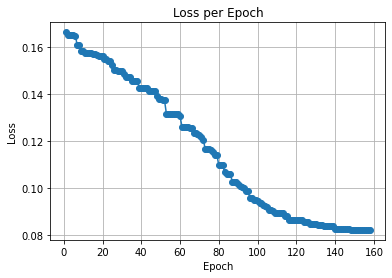

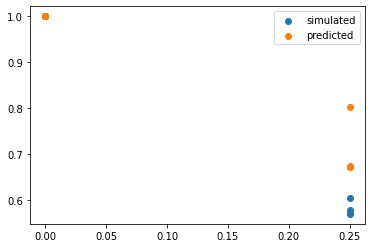

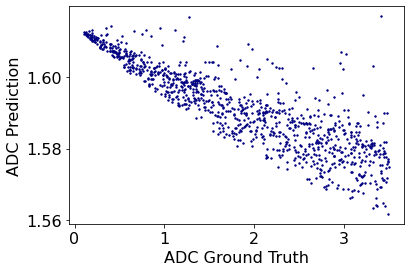

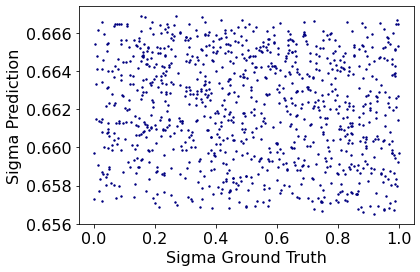

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


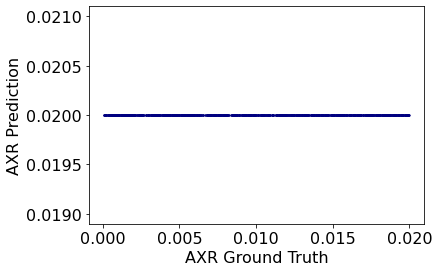

[(-0.8715316724021048, 3.779880403451e-311), (-0.0960121488442741, 0.002370519365181852), (nan, nan)]


In [12]:
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

final_pred_E_vox_detached = final_pred_E_vox.detach().numpy()
"""Was having numpy pytorch issues, so this line helps fix it a bit."""

plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, final_pred_E_vox_detached[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [final_pred_adc, final_pred_sigma, final_pred_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)
